# Loading play, search, download log file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

### Play log

In [2]:
df_play = pd.read_json('../data/sample_playlog.json',lines=True)

In [3]:
# filter play log, keep only the record before 2017-04-29
df_play = df_play[df_play['date'] < dt.datetime.strptime('2017-04-29', '%Y-%m-%d')]
print("there're %d play log record" % df_play.shape[0])
df_play.head(5)

there're 3963671 play log record


,date,device,fn,play_time,song_id,song_length,uid
0,2017-03-01,ar,20170301_play.log,139,1967689.0,275.0,154421168.0
1,2017-03-01,ar,20170301_play.log,261,6468891.0,261.0,154422592.0
2,2017-03-01,ar,20170301_play.log,332,20870993.0,332.0,154422592.0
3,2017-03-01,ar,20170301_play.log,86,1691087.0,358.0,154416928.0
4,2017-03-01,ip,20170301_play.log,4,7153193.0,256.0,154421664.0


### Read in churn label

In [4]:
df_label = pd.read_csv('../data/valid_user_id.csv')
# filter with sampled uid
df_label = df_label[df_label['uid'].isin(df_play.uid.unique())]
print("there're %d active user and %d churned user in this subset" % 
      (np.sum(df_label.churn_label), np.sum(df_label.churn_label==False)))

there're 3791 active user and 2369 churned user in this subset


In [5]:
def play_time(x):
    try:
        x_ = int(x)
    except:
        x_ = np.nan
    return x_

df_play['play_time'] = df_play['play_time'].apply(play_time)

In [6]:
def song_length(x):
    try:
        x_ = int(x)
    except:
        x_ = np.nan
    return x_

df_play['song_length'] = df_play['song_length'].apply(song_length)

In [7]:
df_play.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3963671 entries, 0 to 3963670
Data columns (total 7 columns):
date           datetime64[ns]
device         object
fn             object
play_time      float64
song_id        float64
song_length    int64
uid            float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 241.9+ MB


## Data Cleansing and EDA

In [8]:
df_play[df_play['song_length']<0].head()

,date,device,fn,play_time,song_id,song_length,uid
3846,2017-03-01,ar,20170301_play.log,248663.0,10644083.0,-1,154455088.0
4075,2017-03-01,ar,20170301_play.log,200044.0,3385977.0,-1,154455088.0
4104,2017-03-01,ar,20170301_play.log,39050.0,3695609.0,-1,154455088.0
4407,2017-03-01,ar,20170301_play.log,264765.0,4367238.0,-1,154455088.0
5011,2017-03-01,ar,20170301_play.log,257952.0,10644083.0,-1,154455088.0


It looks like that "-1" is the default song_length when it's unknown. When song_length<0, play_time does not look normal either

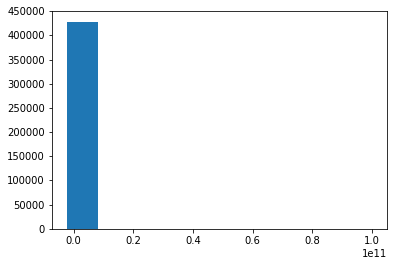

In [9]:
# trying to use song_id to impute the abnormal values
# maybe we can inpute the negative song_length with play time
plt.hist(df_play[df_play.song_id.isin(list(df_play[df_play['song_length']<0].song_id.unique()))]['play_time']
         .dropna().values)
plt.show()

In [10]:
# replace the negative song_length with play time

play_time_median = np.nanmedian( df_play.play_time.values )
song_length_median = np.nanmedian( df_play.song_length.values )
# TODO: remove and impute the outliers of play time
for i, r in df_play.iterrows():
    # cleaning "play_time"
    if r['play_time']>10^6:
        df_play.at(i,'play_time', r['play_time']/10^3)
        
    if r['song_length'] <0 or np.isnan(r['song_length']):
        if r['play_time'] > 0:
            df_play.at(i,'song_length', r['play_time'])
        else:
            df_play.at(i,'play_time',play_time_median)
            df_play.at(i,'song_length',df_play.loc[i]['play_time'])
    elif r['song_length']>0 and ( r['play_time'] < 0 or np.isnan(r['play_time']) ):
        df_play.at(i,'play_time',r['song_length'])
        
            
#df_play[df_play['song_length']<0].song_length = df_play[df_play['song_length']<0].play_time

/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


/Users/jessie/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


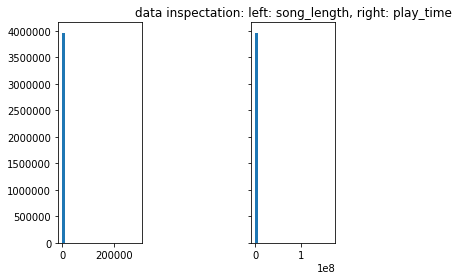

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(df_play['song_length'].dropna().values, bins=30)
axs[1].hist(df_play['play_time'].dropna().values, bins=30)
plt.title('data inspectation: left: song_length, right: play_time')
plt.show()

### Download and search log

Define end_date *** Note - For down and search data, first remove log >= pd.to_date('2017-04-29')

In [12]:
end_date = df_play['date'].max() + dt.timedelta(days=1)
end_date

Timestamp('2017-04-29 00:00:00')

In [13]:
df_down = pd.read_csv('../data/download_sample/sample_down.csv', header=0)
#df_down.dtypes
df_down['date_down'] = pd.to_datetime(df_down['date_down'])
df_down = df_down[df_down['date_down']<end_date]
df_down.dtypes

uid                        int64
song_id_down               int64
song_name_down            object
date_down         datetime64[ns]
dtype: object

In [14]:
df_search = pd.read_csv('../data/search_sample/sample_search.csv', header=0)
#df_search.dtypes
df_search['search_date'] = pd.to_datetime(df_search['search_date_str'])
df_search = df_search[df_search['search_date']<end_date]
df_search.dtypes

uid                       float64
search_date_str            object
search_query               object
search_date        datetime64[ns]
dtype: object

In [15]:
df_down.tail(5)

,uid,song_id_down,song_name_down,date_down
15081,168976944,1123112,All The Way To New York City,2017-04-28
15082,168649680,8397656,平凡之路(DJ版),2017-04-28
15083,168536656,226587,白昼之夜,2017-04-28
15084,169036464,2569569,请你说爱我,2017-04-28
15085,117625392,9883519,迎着风-(电影《四平青年之浩哥大战古惑仔》主题曲),2017-04-28


In [16]:
df_search.tail(5)

,uid,search_date_str,search_query,search_date
314455,168664112.0,2017-04-28 23:50:34,%E6%97%A5%E8%AE%B0%E7%A7%8B%E5%A4%A9,2017-04-28 23:50:34
314456,168832064.0,2017-04-28 23:52:52,%e9%be%9a%e7%88%bd,2017-04-28 23:52:52
314457,168832064.0,2017-04-28 23:53:40,%e8%80%b3%e7%95%94%e4%b8%ad%e5%9b%bd,2017-04-28 23:53:40
314458,168556256.0,2017-04-28 23:55:57,%e6%ad%8c%e5%9c%a8%e9%a3%9e,2017-04-28 23:55:57
314459,168556256.0,2017-04-28 23:56:00,%e6%ad%8c%e5%9c%a8%e9%a3%9e,2017-04-28 23:56:00


In [17]:
df_play.tail(5)

,date,device,fn,play_time,song_id,song_length,uid
3963666,2017-04-28,ar,20170428_3_play.log,207.0,22844813.0,0,169021824.0
3963667,2017-04-28,ar,20170428_3_play.log,0.0,3569565.0,0,169021824.0
3963668,2017-04-28,ar,20170428_3_play.log,49.0,507965.0,213,15768317.0
3963669,2017-04-28,ar,20170428_3_play.log,0.0,23676164.0,0,169021824.0
3963670,2017-04-28,ar,20170428_3_play.log,7.0,6944443.0,150,168894144.0


## Feature Engineering

### Play frequency and mean play time

In [18]:
def compute_play_freq(df, event, event_date, end_date, window):
    df_win = df[(pd.to_datetime(end_date) - df[event_date]).dt.days <= window]
    df_feature = df_win.groupby('uid')[event] \
                       .agg(['count', 'mean']) \
                       .rename(columns={'count':'freq_last_' + str(window) + '_days_play', 
                                        'mean':'mean_last_'+ str(window) + '_days_play_time'})
    return df_feature

In [19]:
play_freq_1 = compute_play_freq(df_play, 'play_time', 'date', '2017-04-29', 1)

In [20]:
play_freq_1.head(5)

,freq_last_1_days_play,mean_last_1_days_play_time
uid,,
12333.0,6,200.000000
1726025.0,20,158.050000
4039655.0,90,186.088889
4213370.0,1,153.000000
6376343.0,1,190.000000


Text(0.5,1,'last 1 day mean play time histogram')

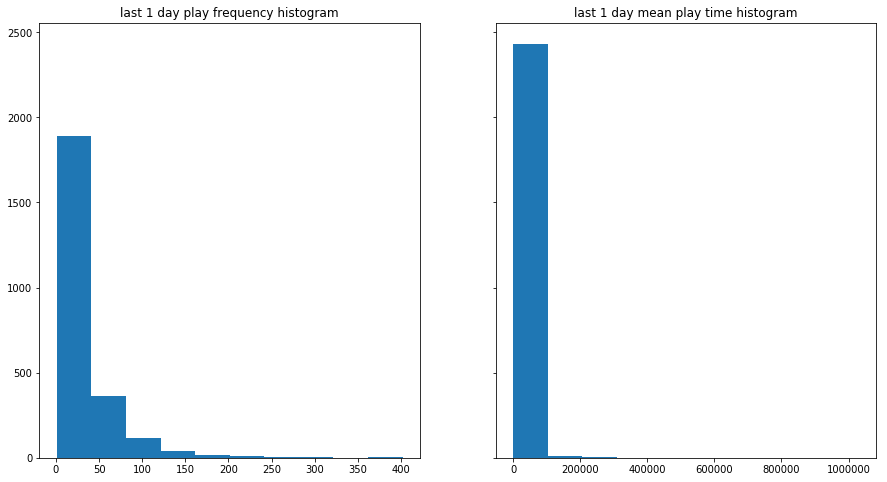

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)
ax1.hist(play_freq_1.freq_last_1_days_play)
ax2.hist(play_freq_1.mean_last_1_days_play_time.dropna())
ax1.set_title('last 1 day play frequency histogram')
ax2.set_title('last 1 day mean play time histogram')

In [22]:
play_freq_1 = compute_play_freq(df_play, 'play_time', 'date', '2017-04-29', 1)
play_freq_3 = compute_play_freq(df_play, 'play_time', 'date', '2017-04-29', 3)
play_freq_7 = compute_play_freq(df_play, 'play_time', 'date', '2017-04-29', 7)
play_freq_14 = compute_play_freq(df_play, 'play_time', 'date', '2017-04-29', 14)
play_freq_30 = compute_play_freq(df_play, 'play_time', 'date', '2017-04-29', 30)

In [23]:
play_feature = pd.merge(play_freq_30, play_freq_14, how='left', left_index=True, right_index=True)
play_feature = pd.merge(play_feature, play_freq_7, how='left', left_index=True, right_index=True)
play_feature = pd.merge(play_feature, play_freq_3, how='left', left_index=True, right_index=True)
play_feature = pd.merge(play_feature, play_freq_1, how='left', left_index=True, right_index=True)

In [24]:
play_feature.head(5)

,freq_last_30_days_play,mean_last_30_days_play_time,freq_last_14_days_play,mean_last_14_days_play_time,freq_last_7_days_play,mean_last_7_days_play_time,freq_last_3_days_play,mean_last_3_days_play_time,freq_last_1_days_play,mean_last_1_days_play_time
uid,,,,,,,,,,
12333.0,262,217.133588,140.0,221.242857,34.0,197.794118,13.0,192.615385,6.0,200.00
104057.0,215,110.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269510.0,37,212.837838,23.0,206.521739,23.0,206.521739,3.0,230.333333,NaN,NaN
1335605.0,1,153.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1726025.0,384,222.036458,135.0,225.125926,65.0,183.400000,25.0,165.640000,20.0,158.05


The NaN value in table means that this user has no record within that time window, so we should replace them by 0

In [25]:
play_feature = play_feature.fillna(0)
print("the shape of play log features are:", play_feature.shape)

the shape of play log features are: (4992, 10)


### Last_since

In [34]:
def compute_last_play(df, end_date):
    #df_win = df[(pd.to_datetime(end_date) - df[event_date]).dt.days <= window]
    df_feature = df.groupby('uid')['date'].agg({'max':'max'})
    df_feature['last_play'] = pd.to_datetime(end_date) - df_feature['max'] # unit: days
    df_feature['last_play'] = df_feature['last_play'].apply(lambda x: (x / np.timedelta64(1, 'D')).astype(int))
    return df_feature

df_last_play = compute_last_play(df_play, '2017-04-29')
df_last_play.head(5)

/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,max,last_play
uid,,
12333.0,2017-04-28,1
104057.0,2017-04-12,17
269510.0,2017-04-26,3
1335605.0,2017-03-30,30
1726025.0,2017-04-28,1


In [54]:
def compute_last_search(df, end_date):
    #df_win = df[(pd.to_datetime(end_date) - df[event_date]).dt.days <= window]
    df_feature = df.groupby('uid')['search_date'].agg({'max':'max'})
    df_feature['last_search'] = pd.to_datetime(end_date) - df_feature['max'] # unit: days
    df_feature['last_search'] = df_feature['last_search'].apply(lambda x: (x / np.timedelta64(1, 'D')).astype(int))
    return df_feature

df_last_search = compute_last_search(df_search, '2017-04-29')
df_last_search.head(5)

/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,max,last_search
uid,,
12333.0,2017-04-13 07:23:54,15
269510.0,2017-04-24 23:53:43,4
1335605.0,2017-03-30 23:39:35,29
3962203.0,2017-04-26 22:28:32,2
3970263.0,2017-03-01 06:15:07,58


In [56]:
def compute_last_download(df, end_date):
    #df_win = df[(pd.to_datetime(end_date) - df[event_date]).dt.days <= window]
    df_feature = df.groupby('uid')['date_down'].agg({'max':'max'})
    df_feature['last_down'] = pd.to_datetime(end_date) - df_feature['max'] # unit: days
    df_feature['last_down'] = df_feature['last_down'].apply(lambda x: (x / np.timedelta64(1, 'D')).astype(int))
    return df_feature

df_last_down = compute_last_download(df_down, '2017-04-29')
df_last_down.head(5)

/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,max,last_down
uid,,
269510,2017-04-24,5
3962203,2017-04-23,6
4039655,2017-04-11,18
4213370,2017-04-22,7
4550267,2017-03-31,29


Text(0.5,1,'download recency')

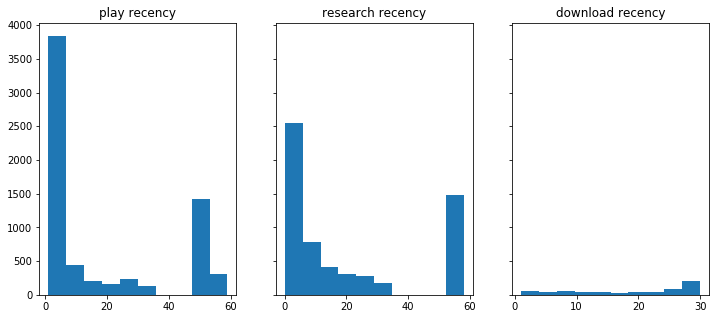

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(5)
f.set_figwidth(12)
ax1.hist(df_last_play.last_play)
ax2.hist(df_last_search.last_search)
ax3.hist(df_last_down.last_down)
ax1.set_title('play recency')
ax2.set_title('research recency')
ax3.set_title('download recency')

### Total active days

In [59]:
def total_active_days(df):
    #df_win = df[(pd.to_datetime(end_date) - df[event_date]).dt.days <= window]
    df_feature = df.groupby('uid')['date'].agg({"active_days": lambda x: x.nunique()})
    return df_feature

df_total_active_days = total_active_days(df_play)
df_total_active_days.head(5)

/Users/jessie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,active_days
uid,
12333.0,16
104057.0,3
269510.0,6
1335605.0,1
1726025.0,27


Text(0.5,1,'total active days')

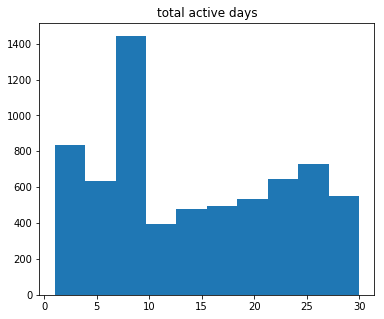

In [69]:
f, (ax1) = plt.subplots(1, 1, sharey=True)
f.set_figheight(5)
f.set_figwidth(6)
ax1.hist(df_total_active_days.active_days)
ax1.set_title('total active days')

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(5)
f.set_figwidth(12)
ax1.hist(df_last_play.last_play)
ax2.hist(df_last_search.last_search)
ax3.hist(df_last_down.last_down)
ax1.set_title('play recency')
ax2.set_title('research recency')
ax3.set_title('download recency')

### Search frequency and download frequency

In [35]:
# function for down and search data 
def compute_freq(df, event, event_date, end_date, window,):
    df_win = df[(pd.to_datetime(end_date) - df[event_date]).dt.days <= window]
    df_feature = df_win.groupby('uid')[event_date] \
                       .agg(['count']) \
                       .rename(columns={'count':'freq_last_' + str(window) + '_days_' + event})
                                       
    
    return df_feature

In [36]:
down_feature = compute_freq(df_down, 'download', 'date_down', end_date, 1)

In [37]:
down_feature.head(5)

,freq_last_1_days_download
uid,
12781898,1
32018846,6
92940152,2
117625392,1
147072480,3


In [38]:
for t in [3,7,14,30]:
    down_t = compute_freq(df_down, 'download', 'date_down', end_date, t)
    down_feature = pd.merge(down_t, down_feature, how='left', left_index=True, right_index=True)

In [39]:
down_feature = down_feature.fillna(0)
down_feature.head(5)

,freq_last_30_days_download,freq_last_14_days_download,freq_last_7_days_download,freq_last_3_days_download,freq_last_1_days_download
uid,,,,,
269510,21,8.0,8.0,0.0,0.0
3962203,8,2.0,2.0,0.0,0.0
4039655,2,0.0,0.0,0.0,0.0
4213370,6,6.0,4.0,0.0,0.0
4550267,3,0.0,0.0,0.0,0.0


In [40]:
print("the shape of download features are:", down_feature.shape)

the shape of download features are: (651, 5)


In [41]:
search_feature = compute_freq(df_search, 'search', 'search_date', end_date, 1)
for t in [3,7,14,30]:
    search_t = compute_freq(df_search, 'search', 'search_date', end_date, t)
    search_feature = pd.merge(search_t, search_feature, how='left', left_index=True, right_index=True)

In [42]:
search_feature = search_feature.fillna(0)
print("the shape of search features are:", search_feature.shape)
search_feature.head(5)

the shape of search features are: (4493, 5)


,freq_last_30_days_search,freq_last_14_days_search,freq_last_7_days_search,freq_last_3_days_search,freq_last_1_days_search
uid,,,,,
12333.0,1,0.0,0.0,0.0,0.0
269510.0,84,82.0,82.0,0.0,0.0
1335605.0,1,0.0,0.0,0.0,0.0
3962203.0,63,45.0,7.0,1.0,0.0
4039655.0,17,10.0,8.0,6.0,1.0


## Merge play_feature, search_feature, down_feature 

In [43]:
device_num = df_play[['uid', 'device']].drop_duplicates() \
                                        .groupby('uid')['device'] \
                                        .agg(['max', 'count']) 

device_num.head()

,max,count
uid,,
12333.0,ip,1
104057.0,ar,1
269510.0,ar,1
1335605.0,ar,1
1726025.0,ar,1


In [44]:
print('unique uid in df_play:',df_play['uid'].unique().shape[0])
device_num.describe()

unique uid in df_play: 6739


,count
count,6739.000000
mean,1.454222
std,0.497937
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [45]:
device_num['device'] = np.where(device_num['count'] == 1, device_num['max'], 'both')

In [46]:
device_num['device'].value_counts()

ar      3570
both    3061
ip       108
Name: device, dtype: int64

In [47]:
play_feature_all = device_num.join(play_feature, how='left').drop(['max','count'], axis=1)
play_feature_all.head()

,device,freq_last_30_days_play,mean_last_30_days_play_time,freq_last_14_days_play,mean_last_14_days_play_time,freq_last_7_days_play,mean_last_7_days_play_time,freq_last_3_days_play,mean_last_3_days_play_time,freq_last_1_days_play,mean_last_1_days_play_time
uid,,,,,,,,,,,
12333.0,ip,262.0,217.133588,140.0,221.242857,34.0,197.794118,13.0,192.615385,6.0,200.00
104057.0,ar,215.0,110.800000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00
269510.0,ar,37.0,212.837838,23.0,206.521739,23.0,206.521739,3.0,230.333333,0.0,0.00
1335605.0,ar,1.0,153.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00
1726025.0,ar,384.0,222.036458,135.0,225.125926,65.0,183.400000,25.0,165.640000,20.0,158.05


In [64]:
df_all = play_feature_all.join(search_feature, how='left') \
                         .join(down_feature, how='left') \
                         .join(df_last_play.drop('max', axis = 1), how = 'left')\
                         .join(df_label.set_index('uid').drop('count', axis = 1), how = 'left')\
                         .join(df_last_search.drop('max', axis = 1), how = 'left')\
                         .join(df_last_down.drop('max', axis = 1), how = 'left')\
                         .join(df_total_active_days, how = 'left')\
                         .dropna(subset=['churn_label'])\
                         .fillna(0)

df_all.sample(10)

,device,freq_last_30_days_play,mean_last_30_days_play_time,freq_last_14_days_play,mean_last_14_days_play_time,freq_last_7_days_play,mean_last_7_days_play_time,freq_last_3_days_play,mean_last_3_days_play_time,freq_last_1_days_play,...,freq_last_30_days_download,freq_last_14_days_download,freq_last_7_days_download,freq_last_3_days_download,freq_last_1_days_download,last_play,churn_label,last_search,last_down,active_days
uid,,,,,,,,,,,,,,,,,,,,,
168519760.0,both,560.0,904.682143,248.0,1158.713710,120.0,1142.033333,64.0,1138.859375,29.0,...,0.0,0.0,0.0,0.0,0.0,1,True,9.0,0.0,29
168457632.0,ar,466.0,93.766094,65.0,100.723077,42.0,83.857143,42.0,83.857143,37.0,...,0.0,0.0,0.0,0.0,0.0,1,True,1.0,0.0,14
168047744.0,ar,269.0,128.955390,20.0,295.950000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,8,True,7.0,0.0,13
168380016.0,both,1221.0,111.667486,785.0,99.359236,421.0,78.280285,67.0,115.059701,14.0,...,14.0,0.0,0.0,0.0,0.0,1,True,3.0,27.0,27
168199568.0,ar,324.0,116.188272,89.0,80.573034,24.0,133.416667,0.0,0.000000,0.0,...,5.0,0.0,0.0,0.0,0.0,6,True,7.0,25.0,18
154632336.0,both,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,52,False,56.0,0.0,7
154634944.0,ar,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,51,False,55.0,0.0,9
168748624.0,both,1637.0,93.058644,453.0,81.271523,431.0,76.090487,118.0,189.338983,34.0,...,0.0,0.0,0.0,0.0,0.0,1,True,2.0,0.0,24
38951696.0,ar,129.0,69.271318,30.0,61.700000,30.0,61.700000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,7,True,6.0,0.0,8


In [65]:
df_all.shape

(6160, 26)

In [66]:
df_all.to_csv('../data/feature_matrix/21feature_0318.csv')